In [1]:
import cv2, zarr, gc
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from pathlib import Path
gc.enable()

In [2]:
from config.global_vars import TILE_SHAPE
from config.global_vars import RESIZE

In [3]:
# from https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T

In [4]:
scale = RESIZE
resize=TILE_SHAPE # For pdf

# Input 
path = Path('/home/jupyter/data_2/')
df_train = pd.read_csv(path/"train.csv")
df_info = pd.read_csv(path/"HuBMAP-20-dataset_information.csv")
grp_anatomy = zarr.group(f'/home/jupyter/anatomy')

# PDF Setting
weight_dict = {
    'fbr': 0.01,          # Background Weights
    'cortex_value': 0.6,  # Cortex Weights
    'medulla_value': 0.15 # Medulla Weights
}

# Output
root = zarr.group(f'/home/jupyter/masks_scale{scale}')
g_msk, g_pdf = root.create_groups('labels', 'pdfs', overwrite=True)

2f6ecfcdf with shape (31278, 25794)
Scaling to (12897, 15639)
Saving msk
Resizing PDF
Saving pdf cumsum


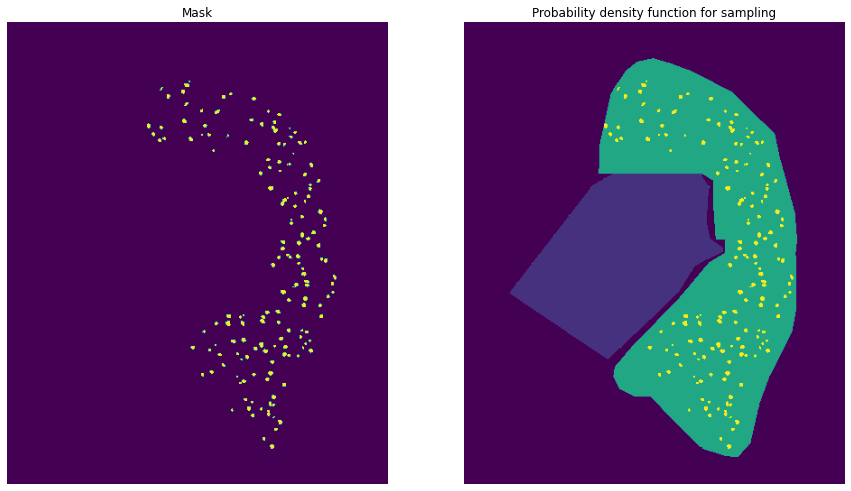

8242609fa with shape (31299, 44066)
Scaling to (22033, 15649)
Saving msk
Resizing PDF
Saving pdf cumsum


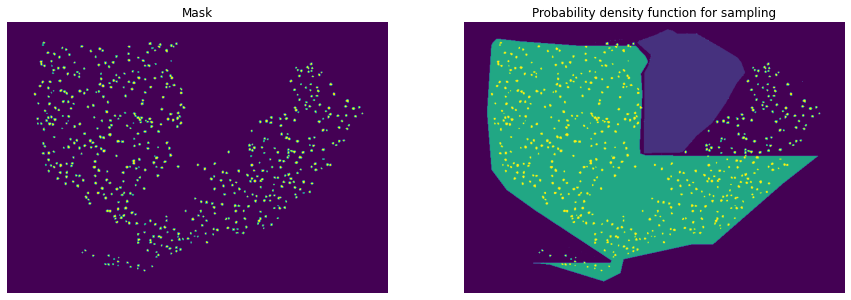

aaa6a05cc with shape (18484, 13013)
Scaling to (6506, 9242)
Saving msk
Resizing PDF
Saving pdf cumsum


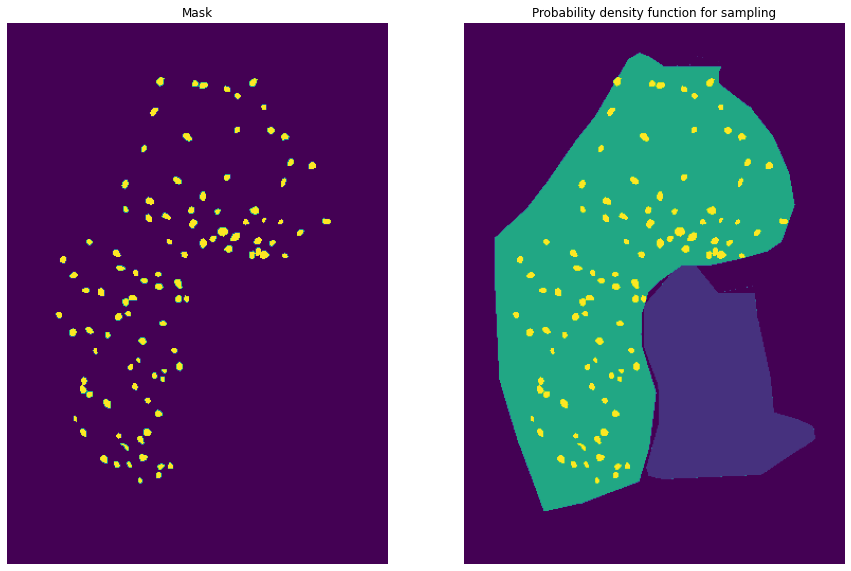

cb2d976f4 with shape (34940, 49548)
Scaling to (24774, 17470)
Saving msk
Resizing PDF
Saving pdf cumsum


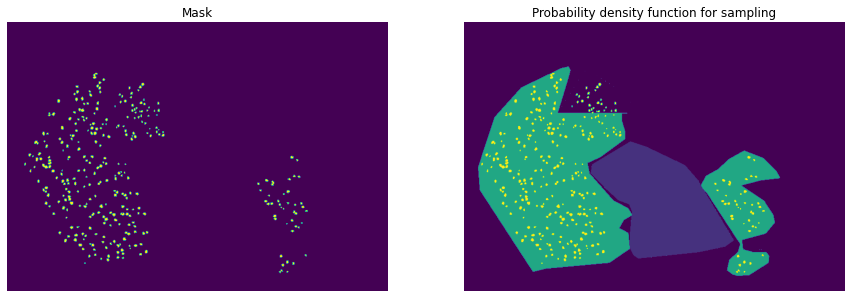

b9a3865fc with shape (31295, 40429)
Scaling to (20214, 15647)
Saving msk
Resizing PDF
Saving pdf cumsum


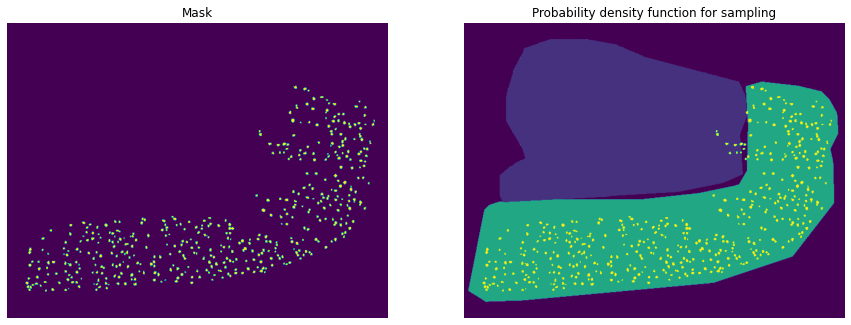

b2dc8411c with shape (14844, 31262)
Scaling to (15631, 7422)
Saving msk
Resizing PDF
Saving pdf cumsum


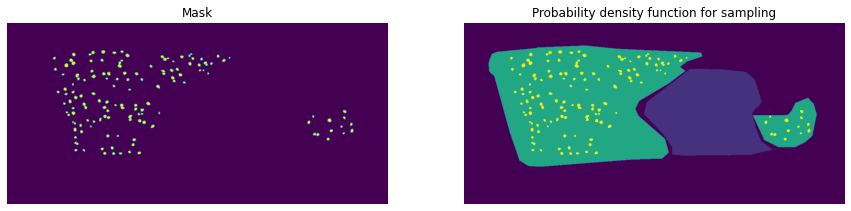

0486052bb with shape (25784, 34937)
Scaling to (17468, 12892)
Saving msk
Resizing PDF
Saving pdf cumsum


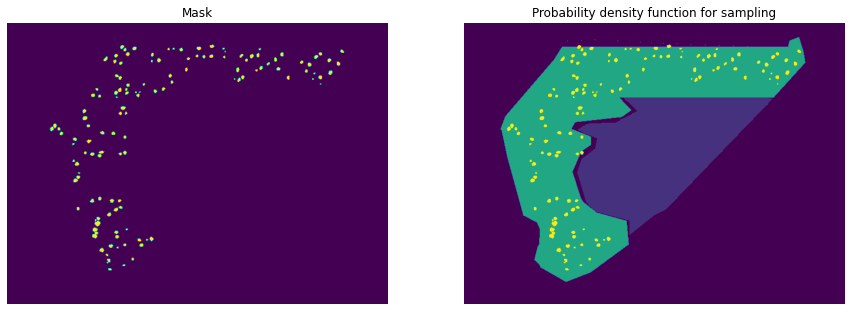

e79de561c with shape (16180, 27020)
Scaling to (13510, 8090)
Saving msk
Resizing PDF
Saving pdf cumsum


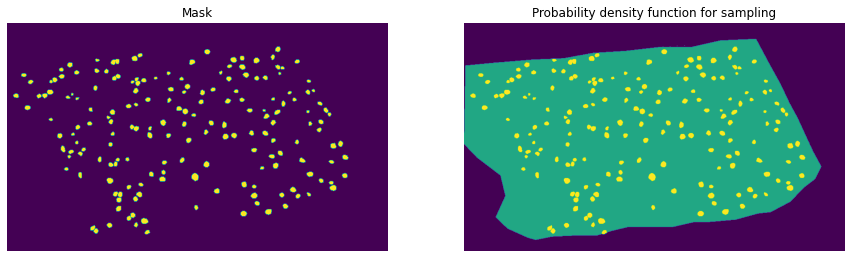

095bf7a1f with shape (38160, 39000)
Scaling to (19500, 19080)
Saving msk
Resizing PDF
Saving pdf cumsum


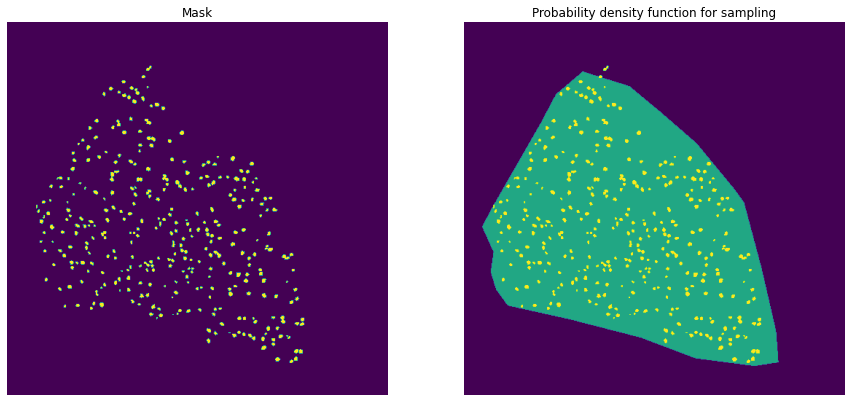

54f2eec69 with shape (30440, 22240)
Scaling to (11120, 15220)
Saving msk
Resizing PDF
Saving pdf cumsum


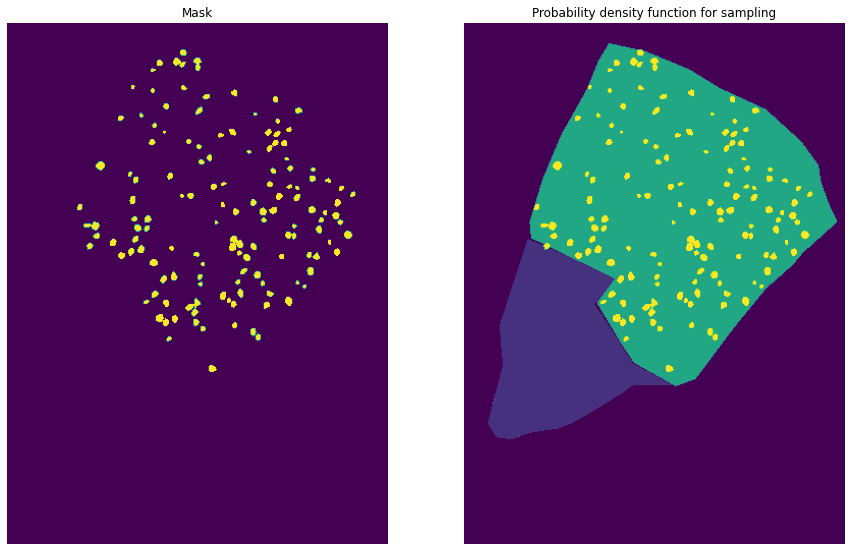

4ef6695ce with shape (39960, 50680)
Scaling to (25340, 19980)
Saving msk
Resizing PDF
Saving pdf cumsum


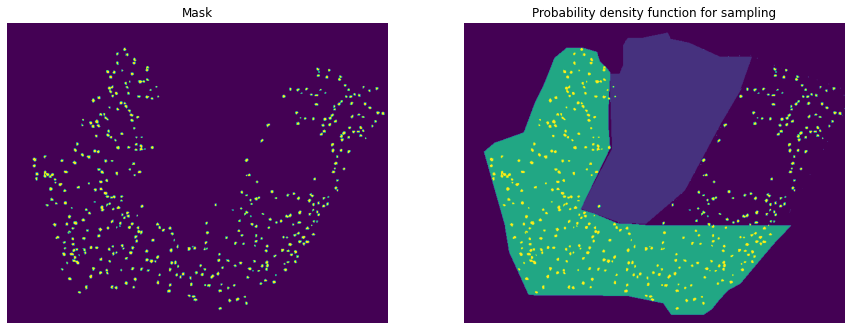

26dc41664 with shape (38160, 42360)
Scaling to (21180, 19080)
Saving msk
Resizing PDF
Saving pdf cumsum


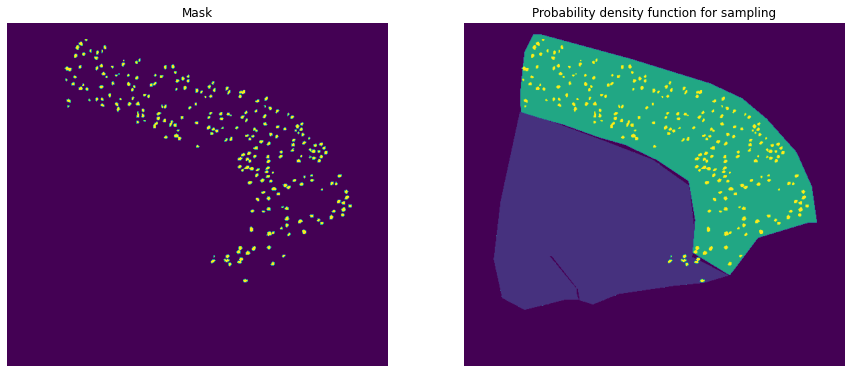

c68fe75ea with shape (26840, 49780)
Scaling to (24890, 13420)
Saving msk
Resizing PDF
Saving pdf cumsum


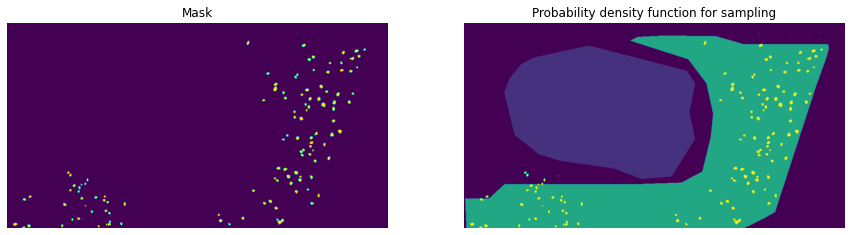

afa5e8098 with shape (36800, 43780)
Scaling to (21890, 18400)
Saving msk
Resizing PDF
Saving pdf cumsum


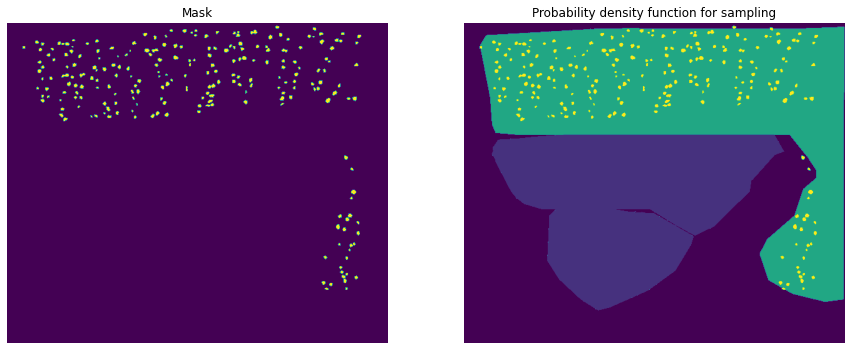

1e2425f28 with shape (26780, 32220)
Scaling to (16110, 13390)
Saving msk
Resizing PDF
Saving pdf cumsum


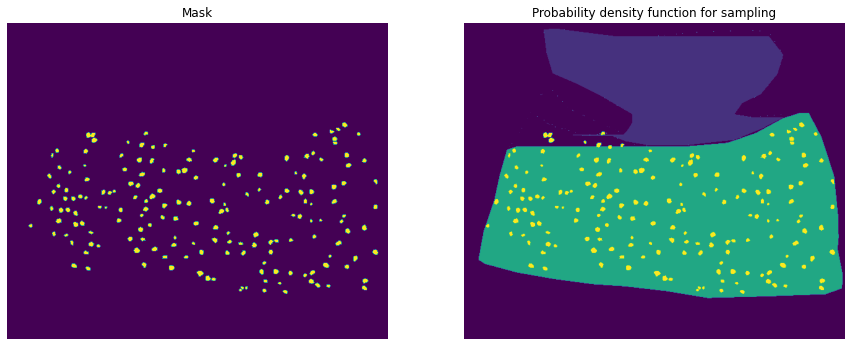

In [5]:
for _, row in df_train.iterrows():
    
    idx = row.id
    img_info = df_info[df_info.image_file==f'{idx}.tiff']
    shape = (img_info.height_pixels.values[0], img_info.width_pixels.values[0])
    print(idx, 'with shape', shape)
    
    msk = rle2mask(row.encoding, (shape[1], shape[0])).astype('uint8')
    
    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(15,15))
    resize_w = int((msk.shape[1]/msk.shape[0])*resize)
    ax[0].imshow(cv2.resize(msk, dsize=(resize_w, resize)))
    ax[0].set_title('Mask')
    ax[0].set_axis_off()
    
    anatomy = grp_anatomy[idx][:]
    
    if scale:
        new_size = (msk.shape[1] // scale, msk.shape[0] // scale)
        print('Scaling to', new_size)
        msk = cv2.resize(msk, new_size)
        anatomy = cv2.resize(anatomy, new_size)
        
    anatomy = anatomy.astype('float16')     
    anatomy[anatomy==0] = weight_dict['fbr']
    anatomy[anatomy==1] = weight_dict['cortex_value']
    anatomy[anatomy>1] = weight_dict['medulla_value']
    anatomy[msk>0] = 1
    
    print('Saving msk')
    g_msk[idx] = msk
    del msk
    gc.collect()
        
    if resize:
        print('Resizing PDF')
        if anatomy.shape[0]>resize:
            resize_w = int((anatomy.shape[1]/anatomy.shape[0])*resize)
            anatomy = cv2.resize(anatomy[:].astype('float32'), dsize=(resize_w, resize))
            
    ax[1].imshow(anatomy)
    ax[1].set_title('Probability density function for sampling')
    ax[1].set_axis_off() 
            
    print('Saving pdf cumsum')
    g_pdf[idx] = np.cumsum(anatomy/np.sum(anatomy)) 

    plt.show()

In [6]:
g_pdf[idx]

<zarr.core.Array '/pdfs/1e2425f28' (315392,) float32>